## 5.2-5.4 Realistic Synthetic Spectra

In [1]:
import numpy as np
import pylab as plt
import utils
from scipy.optimize import minimize

c = 299792458. # m/s
np.random.seed(42)
sqrttwopi = np.sqrt(2. * np.pi)

Generate the data:

In [2]:
fwhms = np.asarray([0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879]) # FWHM of Gaussian fit to line (A)
sigs = fwhms / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = np.asarray([4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87]) # line center (A)
cs = np.asarray([-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536]) # contrast (normalized flux)
ds = np.log(1. + cs) * sigs * sqrttwopi # trust us
dx = 0.01 # A
xs = np.arange(4997.5 + 0.5 * dx, 5002.5, dx) # A
snr = 100.

N = 64
data, ivars, true_rvs = utils.make_data(N, xs, ds, ms, sigs, snr)

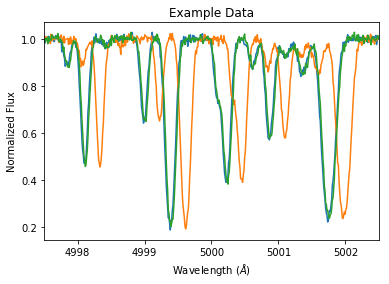

In [3]:
for n in range(0,N,30):
    plt.plot(xs, data[n])
plt.xlim([4997.5,5002.5])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux');

Calculate CRLB:

In [4]:
crlb = utils.calc_crlb(xs, ds, ms, sigs, N, ivars)
print("CRLB:", crlb, "m/s")

CRLB: 10.853233714208377 m/s


# 5.2 Binary mask x-correlation

Let's start by using the binary mask supplied in [the Ceres pipeline](https://github.com/rabrahm/ceres) ([Brahm et al. 2017](https://ui.adsabs.harvard.edu/#abs/2017PASP..129c4002B/abstract)), which claims to reproduce the capabilities of the (proprietary) HARPS instrument pipeline's binary mask. This should yield realistic results for a typical binary-mask-based data reduction.

In [5]:
mask_data = utils.load_mask(4998., 5002.)
(mask_ws, mask_ms, mask_hws) = mask_data # unpack

In [6]:
guess_rvs = true_rvs + np.random.normal(0., 10., size=N) # first-guess RVs
rvs_0 = utils.solve_for_rvs('binary_mask', guess_rvs, 
                            xs, data, ivars, dx, 
                            mask_data=mask_data,
                            grid_hw=1.5e4, max_method='gaussian')

100%|██████████| 64/64 [00:34<00:00,  1.96it/s]


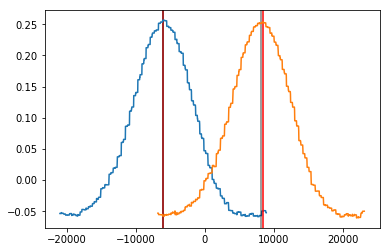

In [7]:
args = (xs, mask_ws, mask_ms, 0.5 * dx, mask_hws)
func = utils.make_mask
for n in [0,20]:
    rvs, objs = utils.get_objective_on_grid(data[n], ivars[n], func, args, 
                                            rvs_0[n], 1.5e4)
    plt.axvline(utils.quadratic_max(rvs, objs), color='r')
    plt.axvline(utils.gaussian_max(rvs, objs, verbose=False), color='k', alpha=0.5)
    plt.plot(rvs, objs)
    '''
    guess_par = (rvs_0[n], 5.e3,
                (max(objs)-min(objs)) * 5.e3 * sqrttwopi,
                min(objs)) # mean, sigma, amplitude, offset
    (mm, sig, amp, offs) = minimize(utils.gaussian_resid, guess_par, args=(rvs, objs))['x']
    objs_g = amp * utils.oned_gaussian(rvs, mm, sig) + offs
    plt.plot(rvs, objs_g, ls='--', c='k', alpha=0.6)
    '''

RV RMS: 10.849828448880995 m/s


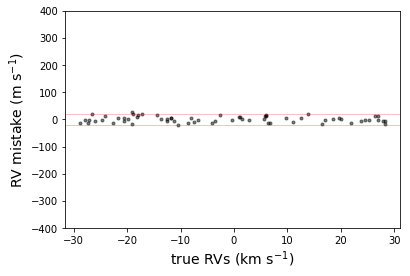

In [8]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)", fontsize=14)
plt.ylabel(r"RV mistake (m s$^{-1}$)", fontsize=14)
print("RV RMS:", np.std(resid), "m/s")

So the binary mask can saturate the CRLB! Note that this is true if & only if none of the selected lines come on & off the observed wavelength grid throughout the year. If we adjust the test case to have less padding at the edges, e.g. trim `xs` down by 0.5 A at either end, then we will get correlated noise in the RV residuals due to the highly asymmetric CCFs.

Text(0, 0.5, 'Normalized Flux')

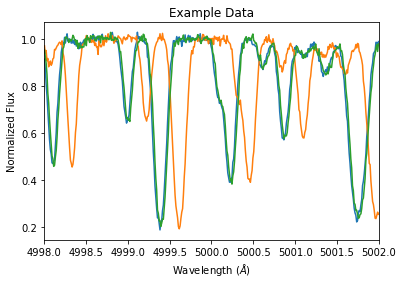

In [9]:
mask = (xs >= 4998.) & (xs < 5002.)
xs_cut = xs[mask]
data_cut = data[:,mask]
ivars_cut = ivars[:,mask]
for n in range(0,N,30):
    plt.plot(xs_cut, data_cut[n])
plt.xlim([4998.,5002.])
plt.title('Example Data')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux')

In [10]:
guess_rvs = true_rvs + np.random.normal(0., 10., size=N) # first-guess RVs
rvs_0 = utils.solve_for_rvs('binary_mask', guess_rvs, 
                            xs_cut, data_cut, ivars_cut, dx, 
                            mask_data=mask_data,
                            grid_hw=1.5e4, max_method='gaussian')

100%|██████████| 64/64 [00:38<00:00,  1.56it/s]


RV RMS: 144.10101070883923 m/s


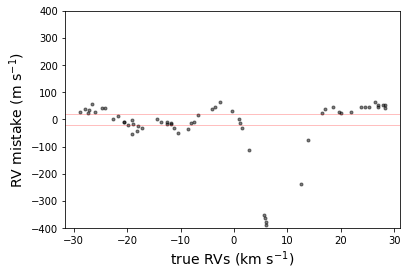

In [11]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)", fontsize=14)
plt.ylabel(r"RV mistake (m s$^{-1}$)", fontsize=14)
print("RV RMS:", np.std(resid), "m/s")

What if the mask we use is slightly wrong?

In [12]:
mask_data_keep = utils.load_mask(4998., 5002.)
(mask_ws, mask_ms, mask_hws) = mask_data_keep # unpack
mask_hws *= np.random.normal(1.0, 0.5, len(mask_hws))
mask_data = (mask_ws, mask_ms, mask_hws)

In [13]:
rvs_0 = utils.solve_for_rvs('binary_mask', guess_rvs, 
                            xs, data, ivars, dx, 
                            mask_data=mask_data,
                            grid_hw=1.5e4, max_method='gaussian')

100%|██████████| 64/64 [00:41<00:00,  1.68it/s]


RV RMS: 11.44151879160288 m/s
performing with 5.4% higher uncertainty than the CRLB


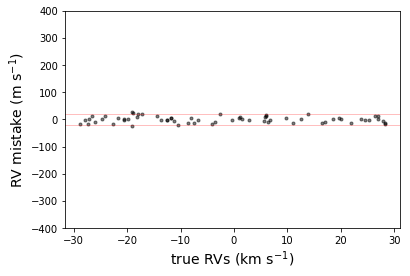

In [14]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)", fontsize=14)
plt.ylabel(r"RV mistake (m s$^{-1}$)", fontsize=14)
print("RV RMS:", np.std(resid), "m/s")
print("performing with {0:.1f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

# 5.3 Rigid Template

How about if we cross-correlate with a stellar spectrum? In these examples we will use a rigid template (i.e. a template spectrum that does not get adjusted during subsequent iterations). One example template would be a single, high-SNR observation of the target star - this is a typical strategy employed with iodine-cell-using instruments.

In [15]:
template_xs = np.arange(4997. + 0.5 * dx, 5003., dx) # A
template = utils.make_synth(0.0, template_xs, ds, ms, sigs)
template += np.random.normal(size=len(template_xs)) / 300. # SNR = 300

Text(0, 0.5, 'Normalized Flux')

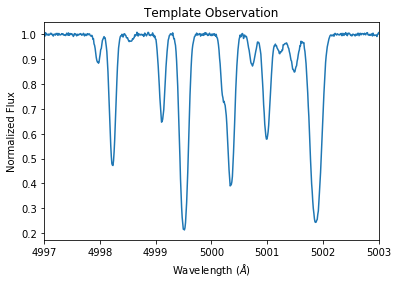

In [16]:
plt.plot(template_xs, template)
plt.xlim([4997.,5003.])
plt.title('Template Observation')
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel(r'Normalized Flux')

In [17]:
rvs_0 = utils.solve_for_rvs('rigid_template', guess_rvs, xs, data, ivars, dx, 
                            template_data=(template_xs, template))

100%|██████████| 64/64 [00:09<00:00,  6.75it/s]


RV RMS: 10.670770950188633 m/s
performing with -1.7% higher uncertainty than the CRLB


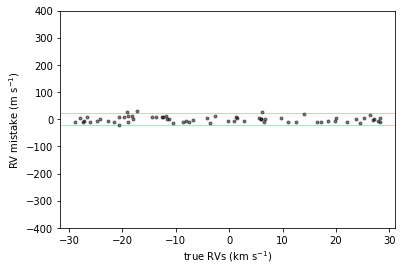

In [18]:
resid = rvs_0 - true_rvs
resid -= np.median(resid) # we don't care about absolute RV
plt.plot(true_rvs*1.e-3, resid, "k.", alpha=0.5)
plt.axhline(2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.axhline(-2. * crlb, color="r", lw=0.5, alpha=0.5)
plt.ylim([-400.,400.])
plt.xlabel(r"true RVs (km s$^{-1}$)")
plt.ylabel(r"RV mistake (m s$^{-1}$)")
print("RV RMS: {0} m/s".format(np.std(resid)))
print("performing with {0:.1f}% higher uncertainty than the CRLB".format((np.std(resid) - crlb)/crlb * 1.e2))

The above example performs well, but we cheated a little bit by expanding the wavelength range of the template beyond that of the other spectra. This is because otherwise at certain barycentric RV shifts, the cross-correlation is prone to mis-matching the lines. We're also assuming that the template observation was taken under exactly identical conditions to the time-series RV spectra, which may not necessarily be the case if the instrument is changing over long timescales.

Also note that if we degrade the template spectrum to a lower SNR, the performance quickly becomes much worse.

## 5.4 Data-driven Template